# Guessing game

Loosely following Lazaridou et al. (2017).

In [1]:
import importlib

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.compat.v1.disable_eager_execution()

### Load image data

In [7]:
# Categorized images
IMG_EMB_FILE = "data/imagenet-4000-vgg19.emb.gz"

# Unsorted images
# IMG_EMB_FILE = "data/esp-10000-vgg19.emb.gz"
# IMG_EMB_FILE = "data/esp-10000-xception.emb.gz"

N_IMAGES = None # = all

In [8]:
from utils.embeddings import load_emb_gz, make_categories
_, fnames, embs = load_emb_gz(IMG_EMB_FILE, N_IMAGES)
categories = make_categories(fnames)
IMG_SHAPE = embs[0].shape
IMG_N = len(embs)

DONE. 4393 items loaded from data/vgg19-imgnet.emb.gz.
42 categories found.


### Set up agents

In [18]:
import game.game as game
import agent.q_agent as agent
from keras.optimizers import Adam, SGD, Adagrad, Nadam
importlib.reload(agent)
importlib.reload(game)

<module 'game.game' from 'D:\\Pracant\\PycharmProjects\\guessing-game-role-switching\\game\\game.py'>

In [10]:
BATCH_SIZE = 30
N_SYMBOLS = 10
N_CHOICES = 4
EMB_SIZE = 50
BATCH_SIZE = 30
N_EPISODES = 10000

In [19]:
sender = agent.Sender(input_sizes=[IMG_SHAPE] * N_CHOICES,
                      output_size=N_SYMBOLS,
                      n_symbols=N_SYMBOLS,
                      embedding_size=EMB_SIZE,
                      learning_rate=0.01,
                      gibbs_temp=10,
                      use_bias=False,
                      optimizer=Adam)

In [15]:
sender = agent.SenderInformed(input_sizes=[IMG_SHAPE] * N_CHOICES,
                              output_size=N_SYMBOLS,
                              n_symbols=N_SYMBOLS,
                              n_filters=20,
                              embedding_size=EMB_SIZE,
                              learning_rate=0.02,
                              gibbs_temp=10,
                              use_bias=False,
                              optimizer=Adam)

In [20]:
receiver = agent.Receiver(input_sizes=[IMG_SHAPE] * N_CHOICES + [(1,)],
                          output_size=N_CHOICES,
                          n_symbols=N_SYMBOLS,
                          embedding_size=EMB_SIZE,
                          learning_rate=0.01,
                          gibbs_temp=10,
                          mode="dot",  # original with dot product output
                          # mode="dense",  # dense layer + sigmoid instead
                          # mode="cosine",  # cosine distance (NOT WORKING)
                          use_bias=False,
                          optimizer=Adam)

In [13]:
g = game.Game(images=embs,
              images_filenames=fnames,
              categories=categories,
              reward_sender={"success": 1, "fail": 0},
              reward_receiver={"success": 1, "fail": 0})

<IPython.core.display.Javascript object>


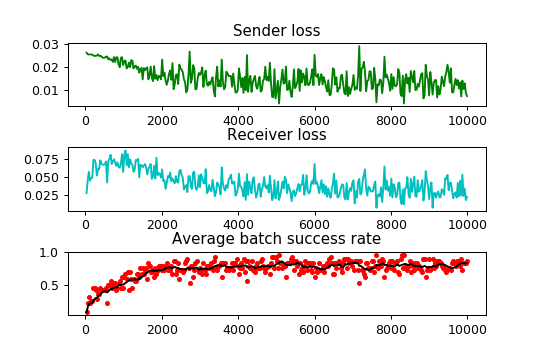

In [21]:
fig = plt.figure()
plt.subplots_adjust(hspace=0.65)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
plt.ion()

fig.show()
fig.canvas.draw()

t = []
show_steps = 2500
batch_success = []
success_rate = []
sendr_loss = []
recvr_loss = []
success_rate_avg = []
sendr_loss_avg = None
recvr_loss_avg = None
for i in range(N_EPISODES):
    g.reset()
    sender_state = g.get_sender_state(n_images=N_CHOICES, unique_categories=True)
    sender_action, _ = sender.act(sender_state)
    receiver_state = g.get_receiver_state(sender_action)
    receiver_action, _ = receiver.act(receiver_state)
    sender_reward, receiver_reward, success = g.evaluate_guess(receiver_action)
    sender.remember(sender_state, sender_action, sender_reward)
    receiver.remember(receiver_state, receiver_action, receiver_reward)
    batch_success.append(success)

    # TRAIN
    if i and not i % BATCH_SIZE:
        avg_success = sum(batch_success)/len(batch_success)
        batch_success = []
        sender.batch_train()
        receiver.batch_train()
        # PLOT PROGRESS
        t.append(i)
        success_rate.append(avg_success)
        success_rate_avg.append(sum(success_rate[-10:])/min(10, len(success_rate)))
        sendr_loss.append(sender.last_loss)
        recvr_loss.append(receiver.last_loss)
        #       print(success, sender.last_loss, receiver.last_loss)
        ax1.clear()
        ax2.clear()
        ax3.clear()
        ax1.set_title("Sender loss")
        ax2.set_title("Receiver loss")
        ax3.set_title("Average batch success rate")
        ax1.plot(t[-show_steps:], sendr_loss[-show_steps:], "g")
        ax2.plot(t[-show_steps:], recvr_loss[-show_steps:], "c")
        ax3.plot(t[-show_steps:], success_rate[-show_steps:], "r.")
        ax3.plot(t[-show_steps:], success_rate_avg[-show_steps:], "k")
        fig.canvas.draw()
        fig.canvas.flush_events()


In [ ]:
sender.save("sender.weights")
receiver.save("receiver.weights")


In [ ]:
sender.load("sender.weights")
receiver.load("receiver.weights")
